# The Gap-up and Gap-Down Momentum Strategy
In this notebook we explore the gap-up and gap-down strategy for day trading. 

## Data Processing
Here we import the sp500 stocks daily data. The stock data starts in January 2, 2017 to Aug 14, 2020 (The time I loaded the data). For all the aggregate functions we use the exponentially weighted moving average to make it a better representation of the data.
We choose, $$\alpha=.05$$ to have some memory of the past.

In [1]:
import pandas as pd
import numpy as np
import utilities as util
%load_ext autoreload
%autoreload 2
alpha = .05

In [2]:
sp500 = util.get_sp500()
head1, head2 = zip(*np.array(sp500.columns))
head1 = np.unique(head1)
head2 = np.unique(head2)
sp500 = sp500.rename_axis(columns=['OHLCV','Ticker'])
print(head1)
print(sp500.head())
print(sp500.shape)
# df.columns.get_level_values(1)

['Adj Close' 'Close' 'High' 'Low' 'Open' 'Volume']
OHLCV       Adj Close                                                \
Ticker              A        AAL         AAP        AAPL       ABBV   
Date                                                                  
2017-01-03  45.055649  44.741226  168.627762  110.193657  51.917995   
2017-01-04  45.646828  45.127758  170.011581  110.070328  52.650063   
2017-01-05  45.104115  44.345032  169.892990  110.630081  53.049370   
2017-01-06  46.509373  44.654255  167.668976  111.863426  53.066010   
2017-01-09  46.654751  45.494972  167.570175  112.888023  53.415398   

OHLCV                                                                 ...  \
Ticker            ABC        ABMD        ABT         ACN        ADBE  ...   
Date                                                                  ...   
2017-01-03  77.229439  112.360001  36.415054  109.415276  103.480003  ...   
2017-01-04  79.145920  115.739998  36.704132  109.678337  104.139999  ..

# Momentum Trading Strategies
In this section, we will implement a basic momentum strategy of the sp500 stocks based on the gap-up and gap-down for Apple stock

In [3]:
import matplotlib.pyplot as plt
import utilities as util

Calculated the adjusted open.
Adjusted open is defined by multiplying the adjustment factor to the opening price. This is necessary in case there is an splits or dividends

In [4]:
adjustment_factor = sp500['Adj Close'] / sp500['Close']
adj_open = sp500['Open'] * adjustment_factor

In [5]:
sp500 = sp500.stack(level=1)
sp500['Adj Open'] = (adj_open).stack(level=0)
#sp500 = sp500.unstack()
sp500.head()

OHLCV               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2017-01-03 A        45.055649   46.490002   46.750000   45.740002   45.930000   
           AAL      44.741226   46.299999   47.340000   46.139999   47.279999   
           AAP     168.627762  170.600006  171.360001  169.309998  170.779999   
           AAPL    110.193657  116.150001  116.330002  114.760002  115.800003   
           ABBV     51.917995   62.410000   63.029999   61.939999   62.919998   

OHLCV                  Volume    Adj Open  
Date       Ticker                          
2017-01-03 A        1739600.0   44.512925  
           AAL      6737800.0   45.688232  
           AAP       691300.0  168.805674  
           AAPL    28781900.0  109.861607  
           ABBV     9328200.0   52.342256

## The trading strategy.
We will take long positions when there is a gap up and a short position when there is a gap down

Gap up is defined as when today's opening price is greater than yesterday's closing price.

Gap down is defined as when today's opening price is less than yesterday's closing price

In [6]:
# Returns from previous day close to today's open
sp500['returns_close_open'] = (sp500['Adj Open'] - sp500.groupby('Ticker').shift()['Adj Close']) / sp500.groupby('Ticker').shift()['Adj Close']

In [503]:
sp500['positions'] = np.nan
long_entry = sp500['Adj Open'] > sp500.groupby('Ticker').shift()['Adj Close']
short_entry = sp500['Adj Open'] < sp500.groupby('Ticker').shift()['Adj Close']
sp500.loc[long_entry,'positions'] = 1
sp500.loc[short_entry,'positions'] = -1
sp500 = sp500.dropna()

In [463]:
sp500

OHLCV               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2017-01-04 A        45.646828   47.099998   47.380001   46.820000   46.930000   
           AAL      45.127758   46.700001   47.439999   46.349998   46.630001   
           AAP     170.011581  172.000000  173.169998  170.369995  170.369995   
           AAPL    110.070328  116.019997  116.510002  115.750000  115.849999   
           ABBV     52.650063   63.290001   63.799999   62.639999   62.639999   
...                       ...         ...         ...         ...         ...   
2020-08-14 YUM      92.650002   92.650002   93.160004   92.019997   92.680000   
           ZBH     137.320007  137.320007  138.100006  136.259995  137.139999   
           ZBRA    286.029999  286.029999  286.220001  282.899994  284.779999   
           ZION     34.490002   34.490002   34.939999   33.779999   33.820000   
           ZTS     157.050003  157.050003  158.770004  155.740005  158.669998   

OHLCV                  Volume    Adj Open  returns_close_open  positions  
Date       Ticker                                                         
2017-01-04 A        1821300.0   45.482074            0.009464        1.0  
           AAL      5859600.0   45.060115            0.007127        1.0  
           AAP       641700.0  168.400420           -0.001348       -1.0  
           AAPL    21118100.0  109.909047           -0.002583       -1.0  
           ABBV     8674800.0   52.109335            0.003685        1.0  
...                       ...         ...                 ...        ...  
2020-08-14 YUM       781000.0   92.680000           -0.000970       -1.0  
           ZBH       632900.0  137.139999           -0.005583       -1.0  
           ZBRA      163800.0  284.779999           -0.002906       -1.0  
           ZION      836700.0   33.820000           -0.012843       -1.0  
           ZTS      1780200.0  158.669998           -0.001259       -1.0  

[445709 rows x 9 columns]

## Calculating the strategy's return and plotting the cumulative returns

In [504]:
returns = (sp500['Adj Close'] - sp500['Adj Open']) / sp500['Adj Open']
sp500['strategy_returns'] = returns * sp500['positions']

In [466]:
# Showing the cumulative returns
cumulative_strategy_returns = (sp500.strategy_returns+1).groupby('Ticker').cumprod()

<AxesSubplot:title={'center':'Cumulative Momentum Returns for sp500 since 2017'}, xlabel='Date', ylabel='Cumulative Returns'>

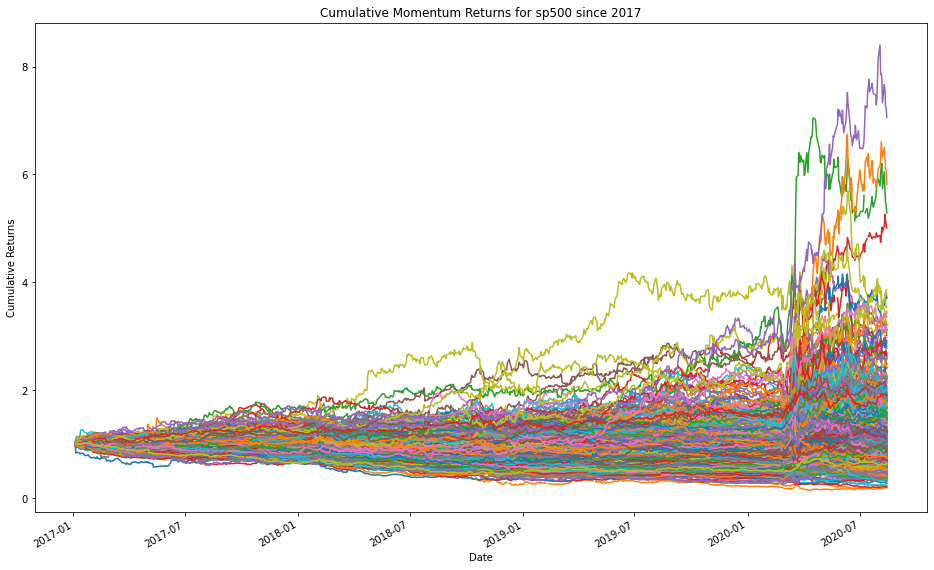

In [467]:
cumulative_strategy_returns.unstack().plot(legend=False,figsize=(16,10), ylabel='Cumulative Returns', title='Cumulative Momentum Returns for sp500 since 2017')

Sp 500 provided a cumulative returns of 

$$\frac{sp500_{20-8-14}}{sp500_{17-01-03}} = \frac{3372.85}{2257.83} = 1.49385$$

In [564]:
(cumulative_strategy_returns['2020-08-14']).mean()

1.2048173823812793

In [468]:
(cumulative_strategy_returns['2020-08-14'] > 1.49385).sum()

117

We see that only 117 stocks in the daily momentum strategies has outperformed the sp500 benchmark since 2017. We can improve on this momentum strategy and at the same time run some clustering analysis on why certain stocks has outperformed in such way. However, we see that the equal weighted return for does not surpass the benchmark.

## Improved Gap-up and Gap-down Strategy

We can improve the existing gap-up and gap-down strategy by calculating the standard deviations of the returns. The standard deviations of returns serves as the benchmark to check whther the momentem is significant or not. We use .25% of standard deviation as a trigger.

In [7]:
alpha = .025
sp500['volatility'] = sp500.groupby('Ticker')['returns_close_open'].apply(lambda x: x.ewm(alpha=alpha).std())

## New strategy. 

Long when returns are above .25 * volatility of returns

Short when returns are below .25 * volatility of returns

If returns are starndard normally distributed then plus-minus .25 * volatility is equivalent to roughly 20%.

In [8]:
sp500['improve_positions'] = np.nan

long_entry = sp500.returns_close_open > .25 * sp500['volatility']
short_entry = sp500.returns_close_open < .25 * sp500['volatility']
sp500.loc[long_entry,'improve_positions'] = 1
sp500.loc[short_entry, 'improve_positions'] = -1
sp500 = sp500.dropna()

In [9]:
sp500['improved_strategy'] = ((sp500['Adj Close'] - sp500['Adj Open']) / sp500['Adj Open']) * sp500.improve_positions

In [10]:
# Showing the cumulative returns
cumulative_improve_strategy_returns = (sp500.improved_strategy+1).groupby('Ticker').cumprod()

<AxesSubplot:title={'center':'Cumulative Improved Momentum Returns for sp500 since 2017'}, xlabel='Date', ylabel='Cumulative Returns'>

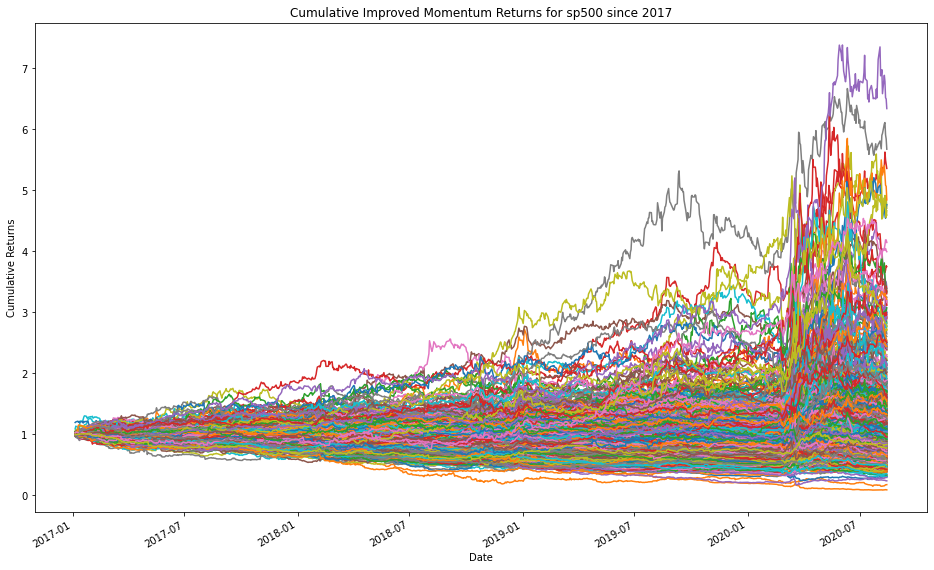

In [11]:
cumulative_improve_strategy_returns.unstack().plot(legend=False,figsize=(16,10), ylabel='Cumulative Returns', title='Cumulative Improved Momentum Returns for sp500 since 2017')

In [562]:
(cumulative_improve_strategy_returns['2020-08-14']).mean()

1.3083816251908476

In [559]:
(cumulative_improve_strategy_returns['2020-08-14'] > 1.49385).sum()

149

This strategy includes move values that beat the sp500 benchmark. However, the range does seem different. However the average for the momemtum strategy does not surpass the benchmark. We can adjust this to only invest in those in the top quintiles. The spread should be able to outperform the benchmark.

Ways we can improve this is to optimize which trigger to use for .25 in either machine learning or insample estimates. At the same time I used expoentially weighted moving standard deviations which could be improve for the first few values.

## Evaluating the strategy's performance
Here we use Pyfolio to give the portfolio strategy from quantopian.

In [13]:
import pyfolio as pf

In [20]:
beat_mkt_ticker = pd.Series(cumulative_improve_strategy_returns['2020-08-14'] > 1.49385)
beat_mkt_ticker = list(beat_mkt_ticker[beat_mkt_ticker].index)

In [40]:
top_portfolio = sp500['improved_strategy'].unstack()[beat_mkt_ticker].mean(axis=1)

Start date,2017-01-05
End date,2020-08-14
Total months,43
,Backtest
Annual return,28.2%
Cumulative returns,145.0%
Annual volatility,13.0%
Sharpe ratio,1.98
Calmar ratio,2.05
Stability,0.78
Max drawdown,-13.7%


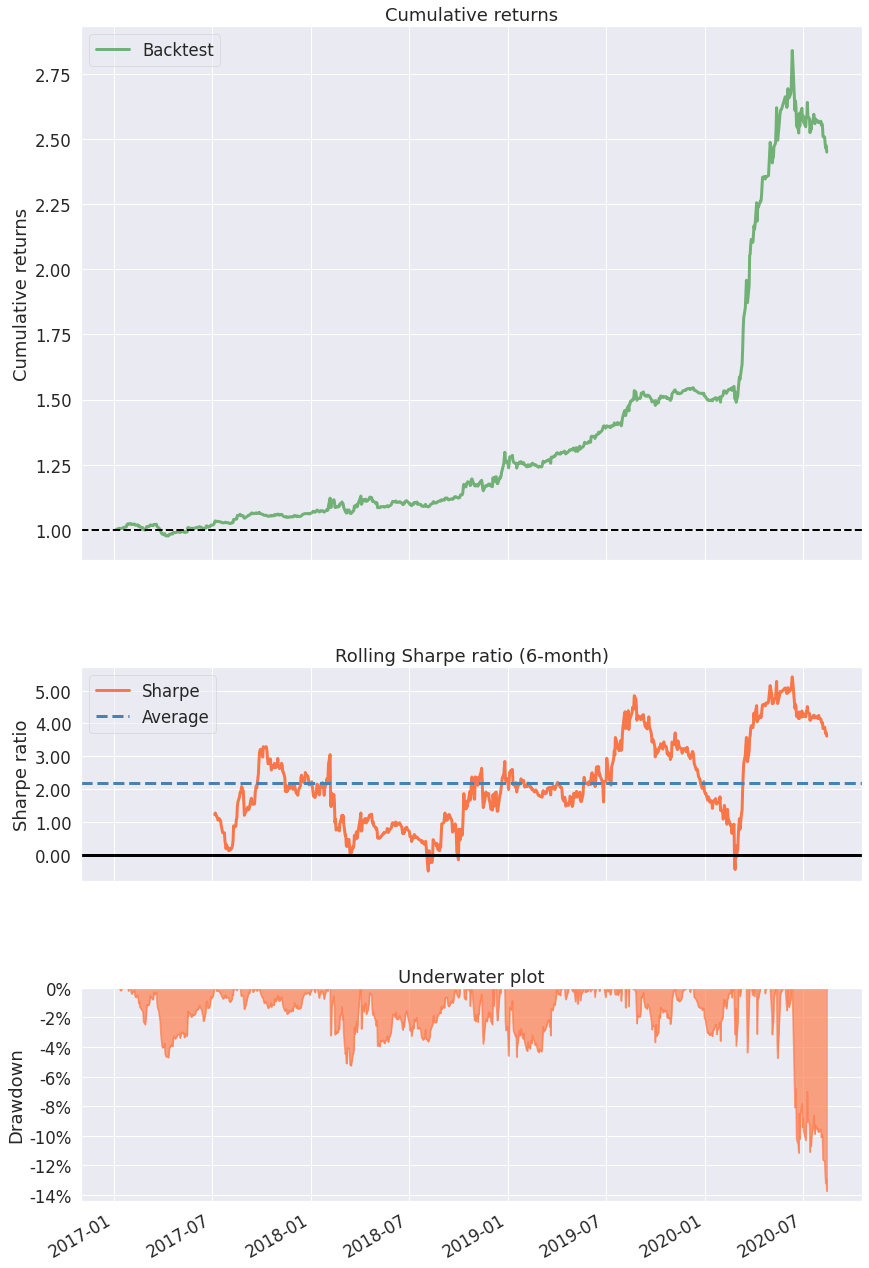

In [38]:
pf.create_simple_tear_sheet(top_portfolio)

From this statistics we see that this strategy would have performed really well from picking the top stocks. We introduce look ahead bias.

In [41]:
momentum_sp500 = sp500['improved_strategy'].unstack().mean(axis=1)

Start date,2017-01-05
End date,2020-08-14
Total months,43
,Backtest
Annual return,5.7%
Cumulative returns,22.2%
Annual volatility,10.7%
Sharpe ratio,0.57
Calmar ratio,0.37
Stability,0.38
Max drawdown,-15.6%


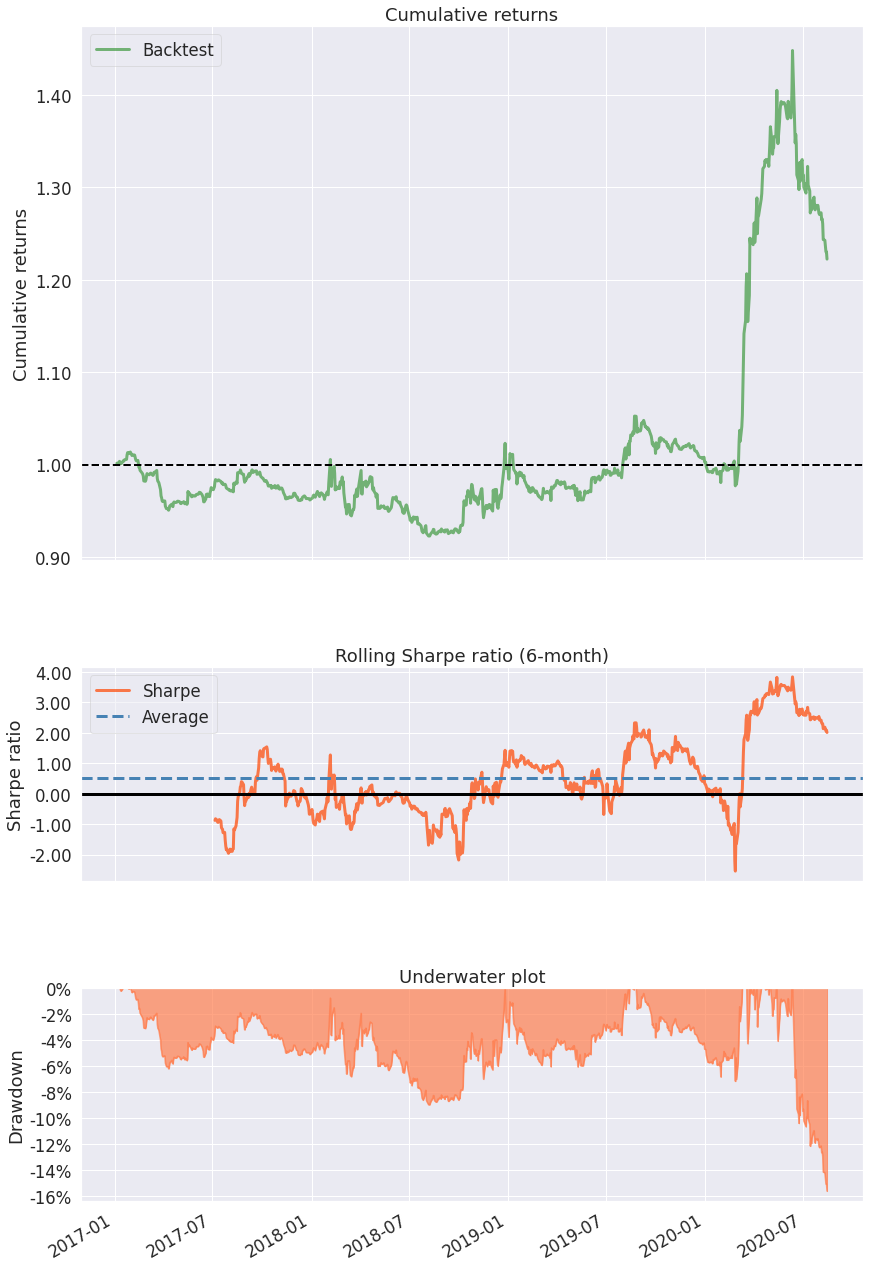

In [42]:
pf.create_simple_tear_sheet(momentum_sp500)

Clearly if we blindy ran this for the sp500 we would not outperform. In addition, it does look like in less volatile times that the strategy does not fair as well. Most of the gains from doing this actually occurred during the market crash in March as seen from the plots. If we were to run this as a spread, this strategy can do better. We explore the biggest losers from this strategy.

In [ ]:
loss_ticker = pd.Series(cumulative_improve_strategy_returns['2020-08-14'] < 1)
loss_ticker = list(loss_ticker[loss_ticker].index)

In [50]:
losers_port = sp500['improved_strategy'].unstack()[loss_ticker].mean(axis=1)

Start date,2017-01-05
End date,2020-08-14
Total months,43
,Backtest
Annual return,-8.9%
Cumulative returns,-28.5%
Annual volatility,9.6%
Sharpe ratio,-0.92
Calmar ratio,-0.28
Stability,0.77
Max drawdown,-31.6%


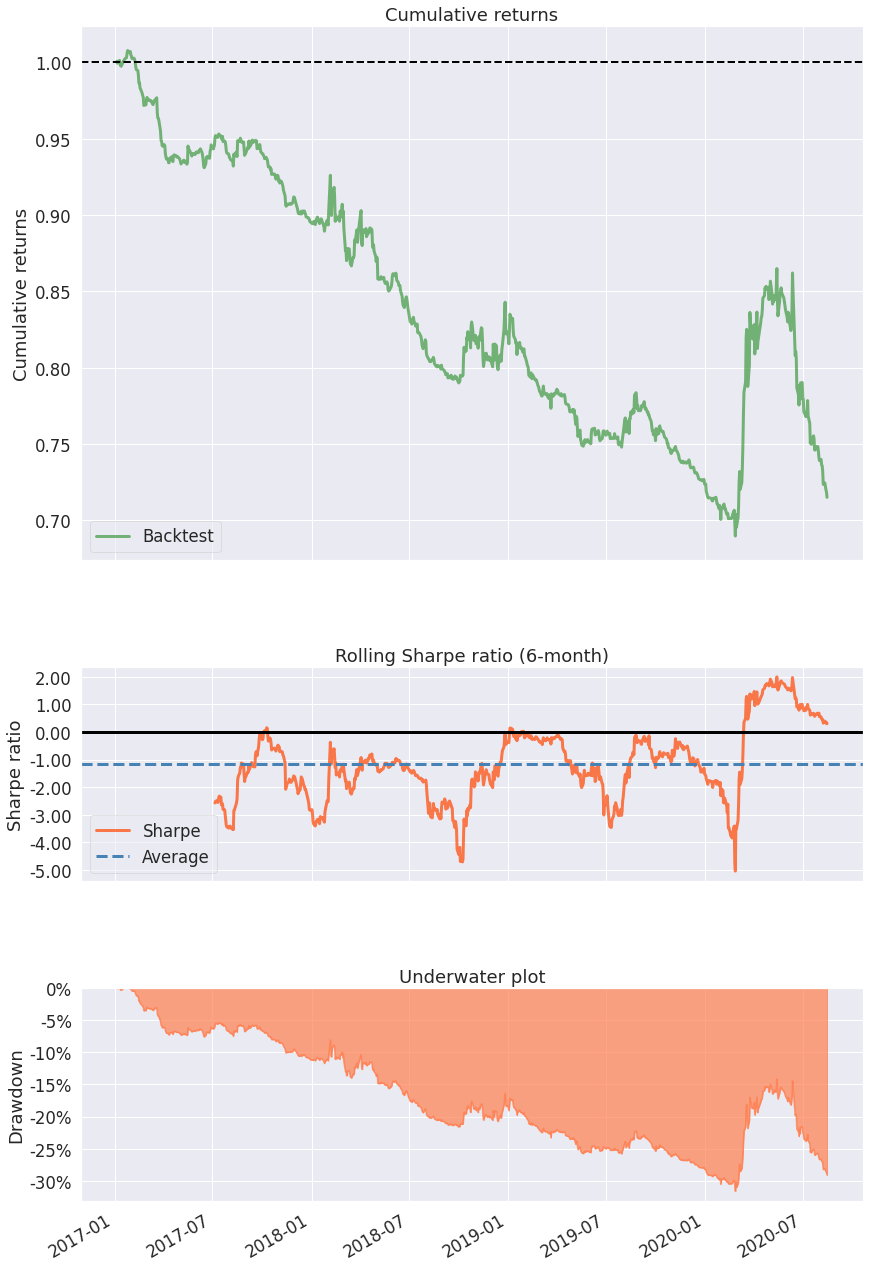

In [51]:
pf.create_simple_tear_sheet(losers_port)

It is interesting to note that the ending sharpe ratio is positive and that these strategy performs really well for covid market crash. Since this portfolio performs poorly, this confirms that we can benefit from making the momentum spread.